In [38]:
import sys
sys.path.append("../") # Enables importing from parent directory
import fpl_draft_league.fpl_draft_league as fpl
import fpl_draft_league.utils as utils
import re
import pandas as pd
import json

## Refresh Data

In [76]:
element_status_df = utils.get_dataframes('../data/element_status.json')
elements_df = utils.get_dataframes('../data/elements.json')
league_entry_df, matches_df, standings_df = utils.get_dataframes('../data/details.json')

# Restrict to owned players
element_status_df = element_status_df[element_status_df['status'] == 'o']

In [83]:
players_df = (pd.merge(element_status_df, league_entry_df, left_on='owner', right_on='entry_id')
              .drop(columns=['in_accepted_trade',
                            'owner',
                            'status',
                            'entry_id',
                            'entry_name',
                            'id',
                            'joined_time',
                            'player_last_name',
                            'short_name',
                            'waiver_pick'])
              .rename(columns={'player_first_name':'team'})
             )

players_df.head(1)

,element,team
0,367,Rebecca


In [84]:
players_df = pd.merge(players_df, elements_df, left_on='element', right_on='id')

In [85]:
players_df.columns

Index(['element', 'team_x', 'added', 'assists', 'bonus', 'bps',
       'chance_of_playing_next_round', 'chance_of_playing_this_round',
       'clean_sheets', 'code', 'creativity', 'draft_rank', 'dreamteam_count',
       'element_type', 'ep_next', 'ep_this', 'event_points', 'first_name',
       'form', 'goals_conceded', 'goals_scored', 'ict_index', 'id',
       'in_dreamteam', 'influence', 'minutes', 'news', 'news_added',
       'news_return', 'news_updated', 'own_goals', 'penalties_missed',
       'penalties_saved', 'points_per_game', 'red_cards', 'saves',
       'second_name', 'squad_number', 'status', 'team_y', 'threat',
       'total_points', 'web_name', 'yellow_cards'],
      dtype='object')

In [86]:
players_df = players_df[['team_x', 'element', 'web_name', 'total_points', 'goals_scored', 'goals_conceded', 'clean_sheets', 'assists', 'bonus', 'draft_rank', 'element_type',  'points_per_game', 'red_cards', 'yellow_cards'                        ]]

In [89]:
players_df[['team_x', 'draft_rank']].groupby('team_x').sum().sort_values(by='draft_rank')

,draft_rank
team_x,
Huw,1649
ben,2069
Liam,2123
Dave,2348
John,2860
Rebecca,2960
Thomas,2987
Cory,3330
Benji,3360


In [40]:
liams_players = list(players_df[players_df['team_x'] == 'Liam']['id'].unique())

In [37]:
import json

def get_element_summary(email_address, element):
    
    json_files = [f"../data/elements/{str(element)}.json"]

    apis = [f"https://draft.premierleague.com/api/element-summary/{str(element)}"]

    # Post credentials for authentication
    pwd = getpass.getpass('Enter Password: ')
    session = requests.session()
    url = 'https://users.premierleague.com/accounts/login/'
    payload = {
     'password': pwd,
     'login': email_address,
     'redirect_uri': 'https://fantasy.premierleague.com/a/login',
     'app': 'plfpl-web'
    }
    session.post(url, data=payload)

    # Loop over the api(s), call them and capture the response(s)
    for file, i in zip(json_files, apis):
        r = session.get(i)
        jsonResponse = r.json()
        with open(file, 'w') as outfile:
            json.dump(jsonResponse, outfile)

In [41]:
for player_id in liams_players:
    
    get_element_summary('lee.gower17@gmail.com', player_id)

Enter Password:  ·········
Enter Password:  ·········
Enter Password:  ·········
Enter Password:  ·······················································
Enter Password:  ·······················································
Enter Password:  ·······················································
Enter Password:  ·······················································
Enter Password:  ·······················································
Enter Password:  ·······················································
Enter Password:  ·······················································
Enter Password:  ·······················································
Enter Password:  
Enter Password:  ·······················································
Enter Password:  ·······················································
Enter Password:  ·······················································


In [50]:
from pandas.io.json import json_normalize

players_dict = {}

for player_id in liams_players:
    
    with open(f'../data/elements/{player_id}.json') as json_data:
        d = json.load(json_data)
        players_dict[player_id] = json_normalize(d['history'])
    

In [62]:
players_df = pd.concat(players_dict, ignore_index=True)

In [64]:
players_df.columns

Index(['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'detail',
       'element', 'event', 'fixture', 'goals_conceded', 'goals_scored',
       'ict_index', 'id', 'influence', 'minutes', 'opponent_team', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'saves', 'threat',
       'total_points', 'yellow_cards'],
      dtype='object')

In [65]:
players_df[['id','total_points']].groupby('id').sum()

,total_points
id,
92,99
110,63
148,83
160,106
161,56
184,115
193,147
219,75
303,85


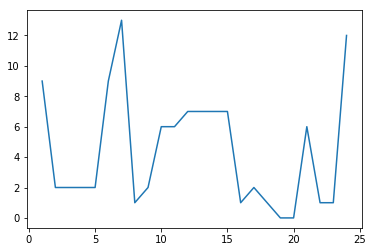

In [47]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot(p160['event'], p160['total_points'])`

In [48]:
p160

,assists,bonus,bps,clean_sheets,creativity,detail,element,event,fixture,goals_conceded,...,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,saves,threat,total_points,yellow_cards
0,0,3,32,1,0.0,WOL (H) 0-0,160,1,5,0,...,90,20,0,0,0,0,0,0.0,9,0
1,0,0,11,0,7.2,CHE (A) 1-1,160,2,14,1,...,90,6,0,0,0,0,0,3.0,2,0
2,0,0,14,0,3.3,SHU (A) 1-2,160,3,27,1,...,90,15,0,0,0,0,0,0.0,2,0
3,0,0,15,0,13.7,BOU (H) 3-1,160,4,36,1,...,90,3,0,0,0,0,0,2.0,2,0
4,0,0,6,0,2.9,MUN (A) 1-0,160,5,45,1,...,90,12,0,0,0,0,0,4.0,2,0
5,0,1,25,0,12.3,TOT (H) 2-1,160,6,56,1,...,90,17,0,0,0,0,0,24.0,9,0
6,0,1,35,1,18.4,NEW (H) 5-0,160,7,66,0,...,90,13,0,0,0,0,0,9.0,13,0
7,0,0,16,0,3.3,LIV (A) 2-1,160,8,74,2,...,90,10,0,0,0,0,0,0.0,1,0
8,0,0,24,0,67.7,BUR (H) 2-1,160,9,86,1,...,90,5,0,0,0,0,0,16.0,2,0
9,0,0,22,1,7.4,SOU (A) 0-9,160,10,98,0,...,90,16,0,0,0,0,0,4.0,6,0
